### Import the Dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ROCAUC

### Data Preprocessing

In [3]:
df = pd.read_csv('movie_metadata.csv')

score_list = list(df['imdb_score'].values)
score_count = dict()

for i in score_list:
  if str(i) in score_count:
    score_count[str(i)] += 1
  else:
    score_count[str(i)] = 1

score_count = {k: v for k, v in sorted(score_count.items(), key = lambda item: item[1], reverse = True)}

column_names = df.columns.values
num_columns = list()
cat_columns = list()

for c in column_names:
  if df[f'{c}'].dtype not in ['float64', 'int64'] :
    cat_columns.append(c)
  else: num_columns.append(c)

remove_score = {6.6, 6.7, 6.8}

float_df = df[num_columns].astype('float64')
float_df = float_df.loc[float_df['imdb_score'].isin(set(score_list) - remove_score)]
float_df['imdb_score'] = float_df['imdb_score'].apply(lambda x: 0 if x < 6.6 else 1)

x = float_df.drop(['imdb_score'], axis = 1)
y = float_df['imdb_score'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)

### Gridsearch

- kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
- degree: int, default=3
-   Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
- gamma: {‘scale’, ‘auto’} or float, default=’scale’
- coef0: float, default=0.0
- C: float, default=1.0  Regularization parameter. (bigger value tables more time to train)
- cache_size: float, default=200 (MB, if you have enough RAM use a bigger value)
- max_iter: int, default=-1

In [4]:
kernels = ['linear', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
Cs = [0, 0.1, 1, 10, 20, 100]

In [5]:
param_dict = dict(kernel = kernels, gamma = gammas, C = Cs)
grid = GridSearchCV(estimator = SVC(cache_size = 500), param_grid = param_dict, cv = 10, scoring = 'roc_auc') 
grid_result = grid.fit(x_train, y_train)
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_param_val

Best Score:  0.8727540251654485
Best Params:  {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}


### Interpret the Result

In [6]:
clf = SVC(kernel = 'rbf', gamma = 'scale', C = 20, cache_size = 500)
clf.fit(x_train, y_train)

SVC(C=20, cache_size=500)

In [7]:
y_pred = pd.DataFrame(clf.predict(x_test))

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       515
           1       0.85      0.67      0.75       373

    accuracy                           0.81       888
   macro avg       0.82      0.79      0.80       888
weighted avg       0.82      0.81      0.81       888

Accuracy on the training set: 0.853

Accuracy on the test set: 0.811



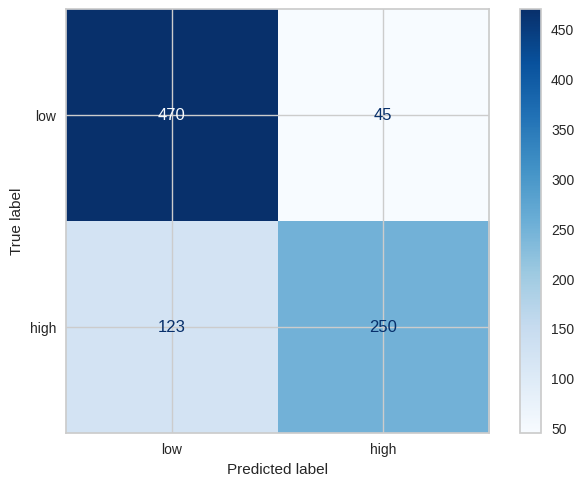

In [8]:
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))
print(f"Accuracy on the training set: {clf.score(x_train, y_train).round(3)}\n")
print(f"Accuracy on the test set: {clf.score(x_test, y_test).round(3)}\n")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels = ['low', 'high'])
disp.plot(cmap = 'Blues')
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


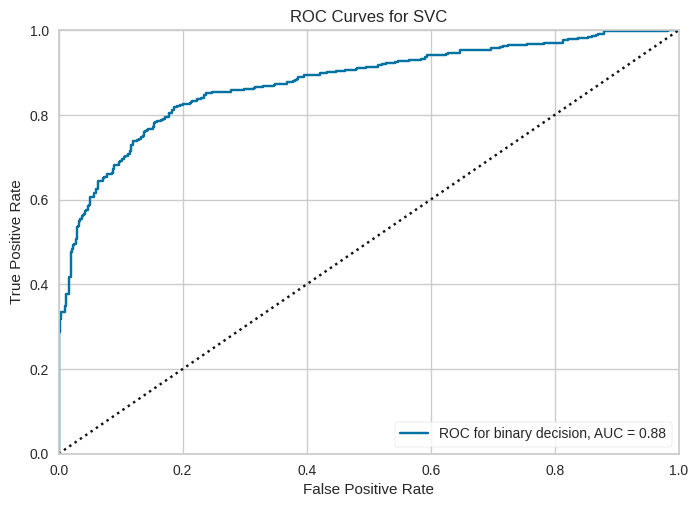

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
visualizer = ROCAUC(clf, classes = ['low', 'high'], binary = True)
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()  

In [24]:
print(f'dual coef length for first class: {len(clf.dual_coef_[0][0: clf.n_support_[0]])}') 
print(f'dual coef length for second class: {len(clf.dual_coef_[0][clf.n_support_[0]: ])}') 
print(clf._intercept_)
print(clf.n_support_) # first value for first class and so on
print(len(clf.support_vectors_)) # total number of support vectors

dual coef length for first class: 849
dual coef length for second class: 872
[-0.89103761]
[849 872]
1721
